<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint6/Module3/JDS_SHR_223_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Cross-Validation

- Do **k-fold cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

In [ ]:
%%capture
!pip install category_encoders==2.*

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
# validation curve = a plot of the influence a single hyperparameter has on the training and validation score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [ ]:
# # mounting your google drive on colab
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# #change your working directory, if you want to or have already saved your kaggle dataset on google drive.
# %cd /content/gdrive/My Drive/Kaggle
# # update it to your folder location on drive that contians the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# # List all files in your Kaggle folder on your google drive.
# !ls

# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id') # merge train features and train labels
  else:
    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(100).T.duplicated().index # change 15 to 100!!!!
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

In [ ]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

# II. Split Data

- One research suggests that validation dataset ratio should be inversely proportional to sqrt of number of parameters
- If training set is too small, we'll have a hard time generalizing the data, which results in a high variance meaning the model "memorizes" the data.

## Split TV from FM

In [ ]:
target = 'status_group'
y = df[target]
X = df.drop(columns = target)

# Training-Validation Split
- if we do cross-validation, we don't have to split the data ourselves, so we skip this step.



# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**, specifically the majority class.

In [ ]:
y.value_counts()

functional                 21927
non functional             15482
functional needs repair     2942
Name: status_group, dtype: int64

In [ ]:
y.value_counts(normalize = True).max()

0.54340660702337

In [ ]:
# if we can predict the functional pumps higher than 54.29% then our model is doing better than the baseline.

# IV. Build Models

- `DecisionTreeClassifier`
- `RandomForestClassifier`

- always use OrdinalEncoder in tree-based models
- we don't need one hot encoding because we aren't dealing with models that involved numerical values like regression, but it's just classification



In [ ]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42))

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators =25, random_state=42) # default number of trees is 100, but just using 25 for today
);

Different cross-validation (CV) techniques:
- K-fold (one fold is one group)
- stratified
- leave one out

**Check cross-validation scores**

![Cross Validation](https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif)

- stratified K-fold is a variation of k-fold, which ensures each fold of dataset has the same proportion of observations with a given label
- useful to deal with imbalanced dataset where one category has more hits than the rest
- from documentation: If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used, otherwise, KFold is used.

In [ ]:
# cross_val_score(model_dt, X, y, cv = 5, n_jobs = -1) # cv = 5 or 10, 5 or 10-fold usually; n_jobs specifies the number of cores in the CPU that we wish to dedicate to complete
                                                     # this task. The value -1 dedicates all but one core to the task

If you need to shuffle your dataset:

In [ ]:
# # create a kfold object to be more specific when we use it in the cross_val_score argument, instead of just using cv=5
# kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cross_val_score(model_dt, X, y, cv = kfold_cv, n_jobs = -1)

In [ ]:
# but today, our dataset is random, so we just need to straight up put cv=5
cv_scores_dt = cross_val_score(model_dt, X, y, cv = 5, n_jobs = -1) # assign to an object so we can work with it later
cv_scores_rf = cross_val_score(model_rf, X, y, cv = 5, n_jobs = -1) # do the same for random rorest

In [ ]:
cv_scores_dt, cv_scores_rf # printed in an array of 5, they are individual validation score for each iteration for both dt and rf

(array([0.74400253, 0.75210438, 0.74915825, 0.74957912, 0.7465011 ]),
 array([0.79292929, 0.79703283, 0.79819024, 0.79882155, 0.79385457]))

In [ ]:
print('CV score DecisionTreeClassifier')
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV score DecisionTreeClassifier
Mean CV accuracy score: 0.746871343345774
STD CV accuracy score: 0.005031487604206908


In [ ]:
print('CV score RandomForestClassifier')
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
Mean CV accuracy score: 0.7926198052998352
STD CV accuracy score: 0.0015148278478563822


In [ ]:
# std 0.24%, as long as doesn't go above 1%, not able to accurately estimate and affects model's confidence

- if we increase k, training set is much bigger than val dataset, the bias would decrease and variance increase, overfitting
- if we decrease k, training set is less than or about the same as val dataset, the bias would increase and variance decrease, underfitting
- therefore, we gotta be careful choosing the k-fold number. Usually 5 or 10, found to result in a model estimate of low bias and moderate variance

# V. Tune Model

### Hyperparameters for different models:
- Ridge regression --> alpha
- Decision trees --> max_depth, max_features, min_sample_split
- Random forest --> n_estimators and max_samples
- neural networks --> number of layers


Different hyperparameter values I want to try out :

*   Simpleimputer - mean, median - 2 values
*   max_depth - range(5,40,5) - 7 values
*   n_estimators (number of trees) - range(25,125,25) - 4 values

> Total combinations of these hyperparameters = 2 * 7 * 4 = 56

Testing out the above hyperparameter combinations with 5-fold Cross Validation will need :

> Total number of models to be fit = 2 * 7 * 4 * 5 = 280


In [ ]:
# created a pipeline first
clf = make_pipeline(       # clf means classifier
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

In [ ]:
# create a param_grid object to tune the different hyperparameters with different values to generate the 280 different models
param_grid = {
    'simpleimputer__strategy':['mean', 'median'],            # 'pipelinestep__parameter':[value, value]   has to be written in a dict format
    'randomforestclassifier__max_depth':range(5,40,5),       # note the double underscores
    'randomforestclassifier__n_estimators':range(25,125,25)
}

- since gridsearch is time-consuming, we should start off with randomized search first, and then can move on to grid search to fine tuning hyperparameter

**`GridSearch`:**

- Cartesian product: an ordered set of sets. The set is created with all possible ordered combinations with one member from each of the sets.

In [ ]:
model_rf_gs = GridSearchCV(clf,
             param_grid=param_grid,
             n_jobs=-1,
             cv=5,
             verbose=1)  # 1 will give you an animated progress bar, 2 will give you the iteration step number

model_rf_gs.fit(X,y)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 40, 5),
                         'randomforestclassifier__n_estimators': range(25, 125, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# to grab results of our 280 fits
# always underscore at the end because they're results of the model
# best_params_ will give you the configuration of the model with the best score
model_rf_gs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

In [ ]:
# the accuracy score of the best model
model_rf_gs.best_score_

0.8042256281996364

In [ ]:
# to get the best model:
model_rf_gs.best_estimator_



Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
hand pump             2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_jobs=-1,
                                        random_state=42))])

In [ ]:
# to get the predictions:
model_rf_gs.predict(X_test)

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional'], dtype=object)

**`RandomizedSearchCV`:**

In [ ]:
# work with the same pipeline and the same grid space
model_rf_rs = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_jobs=-1,
    verbose=1,
    n_iter=7,      # instead of 56 for all possible combo
    cv=5          # still 5-fold, so instead of 280 now we only have 35
)

In [ ]:
# after creating object, fit model to data, search should be much faster than gridsearch
model_rf_rs.fit(X,y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__n_estimators': range(25, 125, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [ ]:
model_rf_rs.best_params_

{'simpleimputer__strategy': 'mean',
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__max_depth': 25}

In [ ]:
model_rf_rs.best_score_

0.802689379767013

# VI. Communicate Results

**Showing Feature Importance**

Plot the feature importance for our `RandomForest` model.

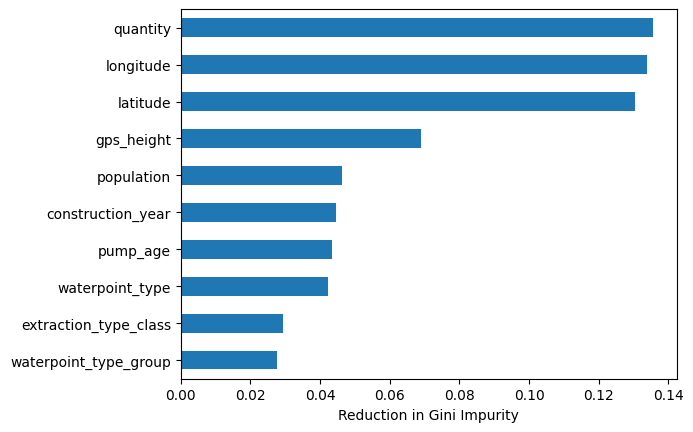

In [ ]:
bestestimator = model_rf_rs.best_estimator_   # grab from random search process
importances = bestestimator.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

# VII. Make Submission

In [ ]:
y_pred = model_rf_rs.predict(X_test)

In [ ]:
submission = pd.DataFrame({'status_group':y_pred}, index=X_test.index)

In [ ]:
submission

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,functional
47083,functional
...,...
26092,functional
919,non functional
47444,non functional


In [ ]:
pd.Timestamp.now().strftime('%Y-%m-%d_%H%M_')

'2023-11-10_0036_'

In [ ]:
datestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H%M_') #string from time format
submission.to_csv(f'{datestamp}submission.csv') #format string

# VIII. Saving a trained model to reuse it in the future

In [ ]:
# Once you have found the best model, you might as well save it and then reload it when you want to test it later

# save model
import pickle

# pickle is a standard way of serializing objects in Python
# serializing is a process of converting an object's state to bits to be stored in a hard drive
filename = 'model_rf_rs_80'  # 80 is the score

#save your model (it will be stored in your current working directory - download to your computer if GDrive is not mounted)
pickle.dump(bestestimator,open(filename,'wb')) # dump method does serializing for us

#load model
model_rf_loaded = pickle.load(open(filename,'rb')) # open it in the write mode